In [1]:
import pandas as pd, numpy as np

%load_ext autoreload
%autoreload 2

df = pd.read_csv('smokers.csv').drop(columns=['eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)'])
df.columns = ['_'.join([word.lower() for word in col_name.split(' ')]) for col_name in df.columns]
df.fasting_blood_sugar = df.fasting_blood_sugar.astype('category') # так надо

n_val = 10_000
X_tr, y_tr = df.iloc[:-n_val, :-1], df.iloc[:-n_val, -1]
X_val, y_val = df.iloc[-n_val:, :-1], df.iloc[-n_val:, -1]
print('train shape:', X_tr.shape, '\nval shape:', X_val.shape, '\n\n')

df.head(3)

train shape: (149256, 19) 
val shape: (10000, 19) 




id  age  height(cm)  weight(kg)  waist(cm)  systolic  relaxation  \
0   0   55         165          60       81.0       135          87   
1   1   70         165          65       89.0       146          83   
2   2   20         170          75       81.0       118          75   

  fasting_blood_sugar  cholesterol  triglyceride  hdl  ldl  hemoglobin  \
0                  94          172           300   40   75        16.5   
1                 147          194            55   57  126        16.2   
2                  79          178           197   45   93        17.4   

   urine_protein  serum_creatinine  ast  alt  gtp  dental_caries  smoking  
0              1               1.0   22   25   27              0        1  
1              1               1.1   27   23   37              1        0  
2              1               0.8   27   31   53              0        1

## Тема урока

<img src='img1.png'>

## 1. Анализ скоров модели

[50]	train's binary_logloss: 0.439972
[100]	train's binary_logloss: 0.422644
[150]	train's binary_logloss: 0.412527
[200]	train's binary_logloss: 0.404118
[250]	train's binary_logloss: 0.395875
[300]	train's binary_logloss: 0.388493
[350]	train's binary_logloss: 0.381897
[400]	train's binary_logloss: 0.375381
[450]	train's binary_logloss: 0.369407
[500]	train's binary_logloss: 0.363542
[550]	train's binary_logloss: 0.358093
[600]	train's binary_logloss: 0.352696
[650]	train's binary_logloss: 0.347579
[700]	train's binary_logloss: 0.342503
[750]	train's binary_logloss: 0.337738
[800]	train's binary_logloss: 0.333169


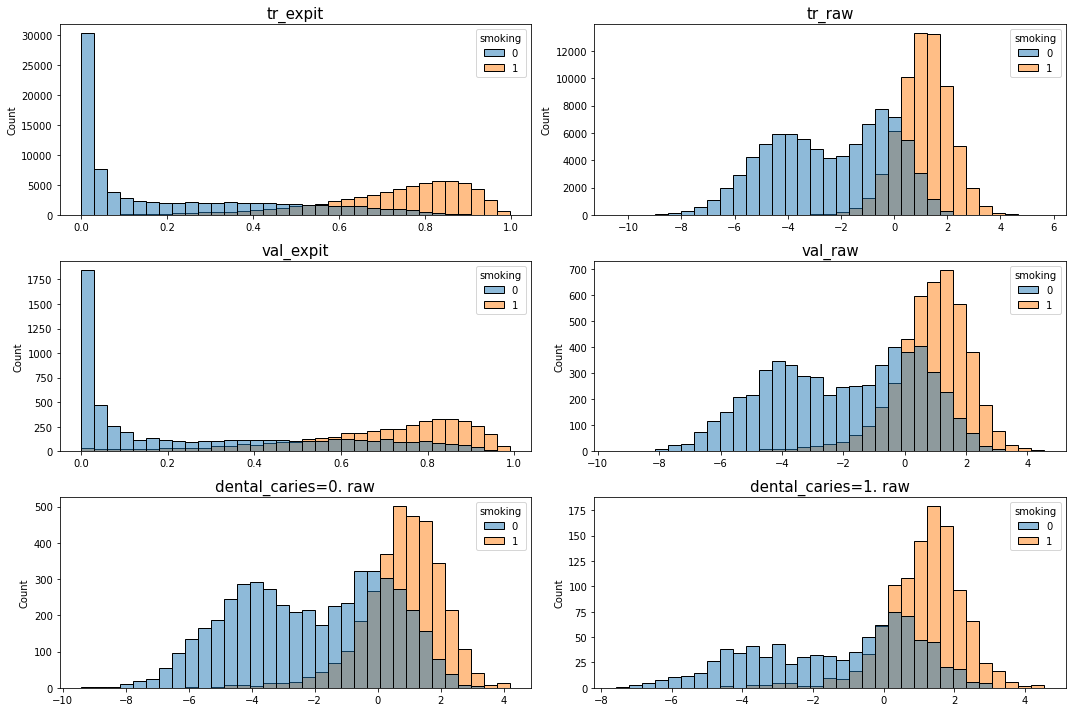

In [2]:
import lightgbm as lgb
from local_manipulations import *


lgb_tr = lgb.Dataset(X_tr, y_tr)
params = {'objective': 'binary', 'metric': 'binary_logloss', 'eta': 0.1, 'verbosity': -1}

model = lgb.train(
    params, lgb_tr, num_boost_round=800,
    valid_sets=[lgb_tr], valid_names=['train'], callbacks=[lgb.log_evaluation(period=50)]
)

plot_scores(model, X_tr, y_tr, X_val, y_val, dental_caries=True)

**Выводы:**
- можно наблюдать "картину предсказаний" ~ текущее положение дел
- можно выделить кластеры объектов (увеличить им вес / проанализировать / выкинуть)
- лучше использовать `raw_scores=True`
    - лучше видна картина
    - можно выделить зоны 100% качества по бокам
- всегда рисуйте трейн и валидацию
- можно рисовать скоры по группам объектов (напр. по кат фичам)

## 2. catboost: `model.get_object_importance`

[статья](https://arxiv.org/abs/1802.06640) <br>
[дока](https://catboost.ai/en/docs/concepts/python-reference_catboost_get_object_importance)<br>
[доклад](https://youtu.be/X8DqoWQVU-M?si=T-bYEmcnYp0BsDZV)<br>
[туториал](https://github.com/catboost/tutorials/blob/master/model_analysis/object_importance_tutorial.ipynb)

**Краткое описание:**

Пытаемся для каждого объекта из val_pool посчитать скоры важности каждого объекта из трейна, эвристически приближая <br><br>


$$L_{full\_trained}(x_{val_j}) - L_{trained\_wo\_x_{train_i}}(x_{val_j})$$

In [157]:
import catboost as cb

cb_tr = cb.Pool(X_tr, y_tr, cat_features=['systolic'])
val_pool = cb.Pool(X_val, y_val, cat_features=['systolic']).slice([0, 1, 2])
cb_tr.quantize()

params = {'objective': 'Logloss', 'eta': 0.1, 'verbose': False, 'iterations': 50, 'thread_count': 16}

model = cb.CatBoost(params)
%time model.fit(cb_tr)

CPU times: total: 7.73 s
Wall time: 4.89 s


In [159]:
%%time

indices, scores = model.get_object_importance(
    val_pool, cb_tr,
    top_size=-1, # не влияет на скорость
    type='PerObject', # не влияет на скорость
    update_method='SinglePoint', # очень влияет на скорость! лучше SinglePoint :)
    importance_values_sign='All', # не влияет на скорость
    thread_count=16
)
indices, scores

CPU times: total: 4min 22s
Wall time: 21.8 s


([[116360,
   36197,
   146327,
   29820,
   49090,
   42407,
   50418,
   127826,
   11894,
   95557,
   87826,
   140876,
   101071,
   37418,
   81330,
   44489,
   83412,
   37408,
   1522,
   99788,
   20928,
   30263,
   64678,
   21007,
   74183,
   118403,
   16301,
   4112,
   59809,
   49820,
   46896,
   85224,
   107754,
   55799,
   53824,
   110493,
   17478,
   85329,
   80830,
   125625,
   36676,
   24822,
   104853,
   129033,
   126531,
   67947,
   12555,
   100748,
   96665,
   31899,
   123862,
   24388,
   147730,
   148783,
   27121,
   22144,
   133863,
   13160,
   70857,
   110266,
   36404,
   138802,
   69191,
   89892,
   144008,
   55501,
   136262,
   76183,
   34932,
   112618,
   30936,
   61864,
   63978,
   53349,
   7538,
   79978,
   58150,
   123156,
   131031,
   63455,
   102923,
   70648,
   59671,
   92771,
   111954,
   144770,
   49777,
   138416,
   133766,
   1894,
   72732,
   48871,
   86147,
   95701,
   19051,
   19356,
   33262,
   12

## 3. lightgbm: `model.trees_to_dataframe`

In [15]:
def train_model_get_t(X_tr, y_tr, params=None):
    lgb_tr = lgb.Dataset(X_tr, y_tr)
    if params is None:
        params = {'objective': 'binary', 'metric': 'binary_logloss', 'eta': 0.1, 'verbosity': -1, 'min_data_in_leaf': 1000}

    model = lgb.train(
        params, lgb_tr, num_boost_round=100,
        valid_sets=[lgb_tr], valid_names=['train'], callbacks=[lgb.log_evaluation(period=50)]
    )

    t = model.trees_to_dataframe()
    t['abs_value'] = np.abs(t.value)
    return t

t = train_model_get_t(X_tr, y_tr)
t

[50]	train's binary_logloss: 0.440285
[100]	train's binary_logloss: 0.423693


tree_index  node_depth node_index left_child right_child parent_index  \
0              0           1       0-S0       0-S2        0-S1         None   
1              0           2       0-S2       0-S8        0-S7         0-S0   
2              0           3       0-S8      0-S21       0-S10         0-S2   
3              0           4      0-S21       0-L0       0-L22         0-S8   
4              0           5       0-L0       None        None        0-S21   
...          ...         ...        ...        ...         ...          ...   
6095          99           5      99-S8     99-S10       99-L9        99-S7   
6096          99           6     99-S10      99-L8      99-L11        99-S8   
6097          99           7      99-L8       None        None       99-S10   
6098          99           7     99-L11       None        None       99-S10   
6099          99           6      99-L9       None        None        99-S8   

         split_feature    split_gain threshold decision_type  \
0           height(cm)  32062.099609     162.5            <=   
1           hemoglobin   4464.740234     14.85            <=   
2                  gtp    455.312988      31.5            <=   
3     serum_creatinine    134.218002      0.95            <=   
4                 None           NaN      None          None   
...                ...           ...       ...           ...   
6095               ast      9.483690      30.5            <=   
6096                id      7.746740   94077.5            <=   
6097              None           NaN      None          None   
6098              None           NaN      None          None   
6099              None           NaN      None          None   

     missing_direction missing_type     value        weight   count  abs_value  
0                 left         None -0.251192      0.000000  149256   0.251192  
1                 left         None -0.376008  13190.100000   53597   0.376008  
2                 left         None -0.401633  11047.100000   44889   0.401633  
3                 left         None -0.410412   9306.670000   37817   0.410412  
4                 None         None -0.413495   8731.293912   35479   0.413495  
...                ...          ...       ...           ...     ...        ...  
6095              left         None -0.004853    905.228000    4720   0.004853  
6096              left         None  0.000995    679.386000    3528   0.000995  
6097              None         None -0.007068    432.679585    2237   0.007068  
6098              None         None  0.015137    246.705990    1291   0.015137  
6099              None         None -0.022659    225.842801    1192   0.022659  

[6100 rows x 16 columns]

In [160]:
# как выглядят Partition splits
t.query('split_feature == "systolic"').head(3)

tree_index  node_depth node_index left_child right_child parent_index  \
36            0           7      0-S27      0-L12       0-L28        0-S17   
115           1           7      1-S29      1-L18       1-L30        1-S17   
157           2           5      2-S19       2-L7       2-L20         2-S6   

    split_feature  split_gain  \
36       systolic   95.357803   
115      systolic   76.808701   
157      systolic  115.563004   

                                             threshold decision_type  \
36   23||25||31||33||38||43||46||48||50||51||52||53...            ==   
115  28||33||37||50||53||55||56||57||61||62||63||64...            ==   
157  18||22||24||26||27||28||29||30||32||34||35||36...            ==   

    missing_direction missing_type     value    weight  count  abs_value  
36              right          NaN -0.241080  1466.740   5960   0.241080  
115             right          NaN  0.065816   881.748   3553   0.065816  
157             right          NaN  0.048045  3549.790  14292   0.048045

### 3.1 Первичный анализ адекватности ансамбля

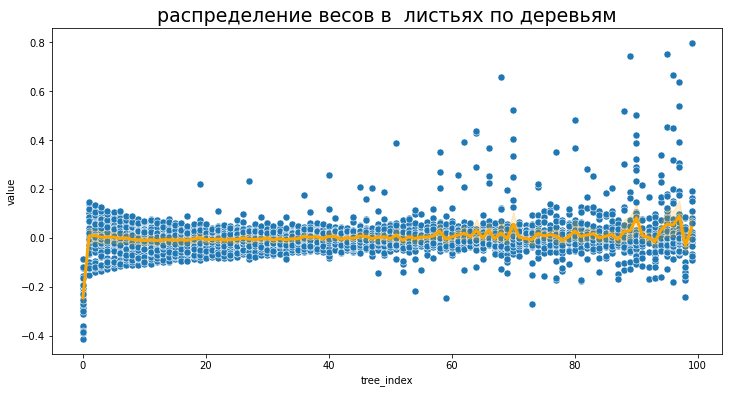

In [40]:
plt.title('распределение весов в  листьях по деревьям', fontsize=19)
sns.scatterplot(t.query('split_gain.isnull()'), x='tree_index', y='value', s=50)
sns.lineplot(t.query('split_gain.isnull()'), x='tree_index', y='value',  color='orange', lw=3)
plt.gcf().set_size_inches(12, 6)

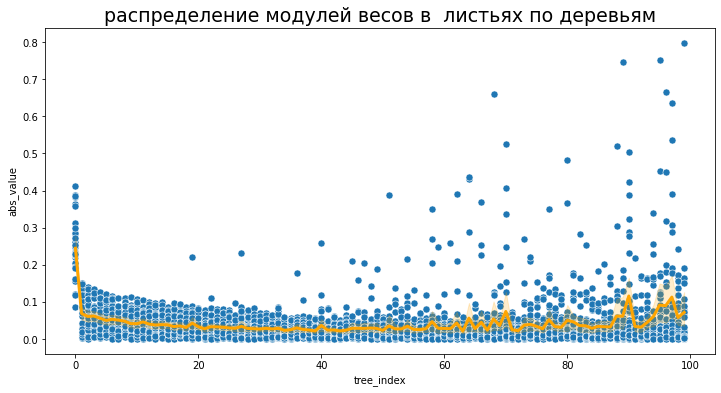

In [41]:
plt.title('распределение модулей весов в  листьях по деревьям', fontsize=19)
sns.scatterplot(t.query('split_gain.isnull()'), x='tree_index', y='abs_value', s=50)
sns.lineplot(t.query('split_gain.isnull()'), x='tree_index', y='abs_value',  color='orange', lw=3)
plt.gcf().set_size_inches(12, 6)

**+ пара слов про [DART](https://arxiv.org/abs/1505.01866) - очень важная веха мысли!**

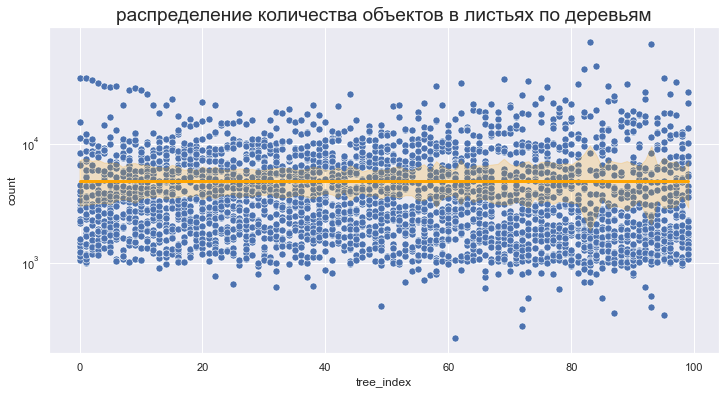

In [16]:
plt.title('распределение количества объектов в листьях по деревьям', fontsize=19)
sns.scatterplot(t.query('split_gain.isnull()'), x='tree_index', y='count', s=50)
sns.lineplot(t.query('split_gain.isnull()'), x='tree_index', y='count',  color='orange', lw=3)
plt.yscale('log')
plt.gcf().set_size_inches(12, 6)

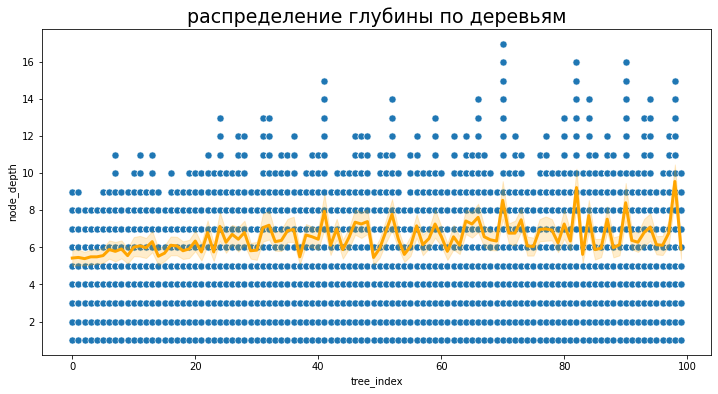

In [43]:
plt.title('распределение глубины по деревьям', fontsize=19)
sns.scatterplot(t, x='tree_index', y='node_depth', s=50)
sns.lineplot(t, x='tree_index', y='node_depth',  color='orange', lw=3)
plt.gcf().set_size_inches(12, 6)

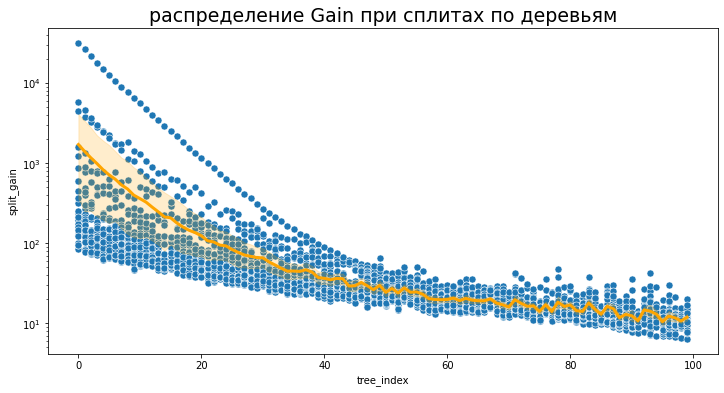

In [44]:
plt.title('распределение Gain при сплитах по деревьям', fontsize=19)
sns.scatterplot(t, x='tree_index', y='split_gain', s=50)
sns.lineplot(t, x='tree_index', y='split_gain',  color='orange', lw=3)
plt.yscale('log')
plt.gcf().set_size_inches(12, 6)

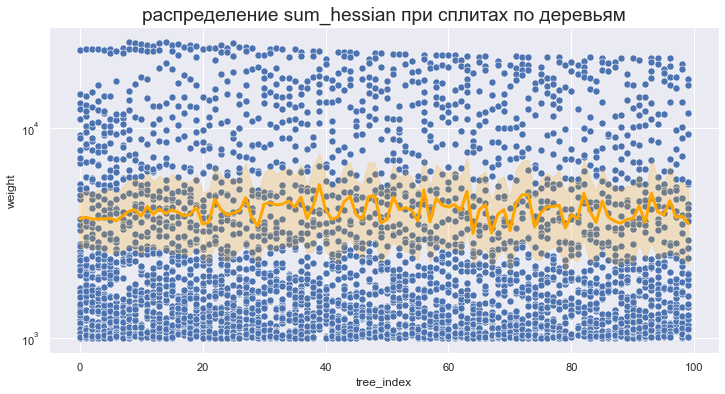

In [162]:
plt.title('распределение sum_hessian при сплитах по деревьям', fontsize=19)
sns.scatterplot(t, x='tree_index', y='weight', s=50)
sns.lineplot(t, x='tree_index', y='weight',  color='orange', lw=3)
plt.yscale('log')
plt.gcf().set_size_inches(12, 6)

### 3.2 Профиль ансамбля

[50]	train's binary_logloss: 0.439972
[100]	train's binary_logloss: 0.422644


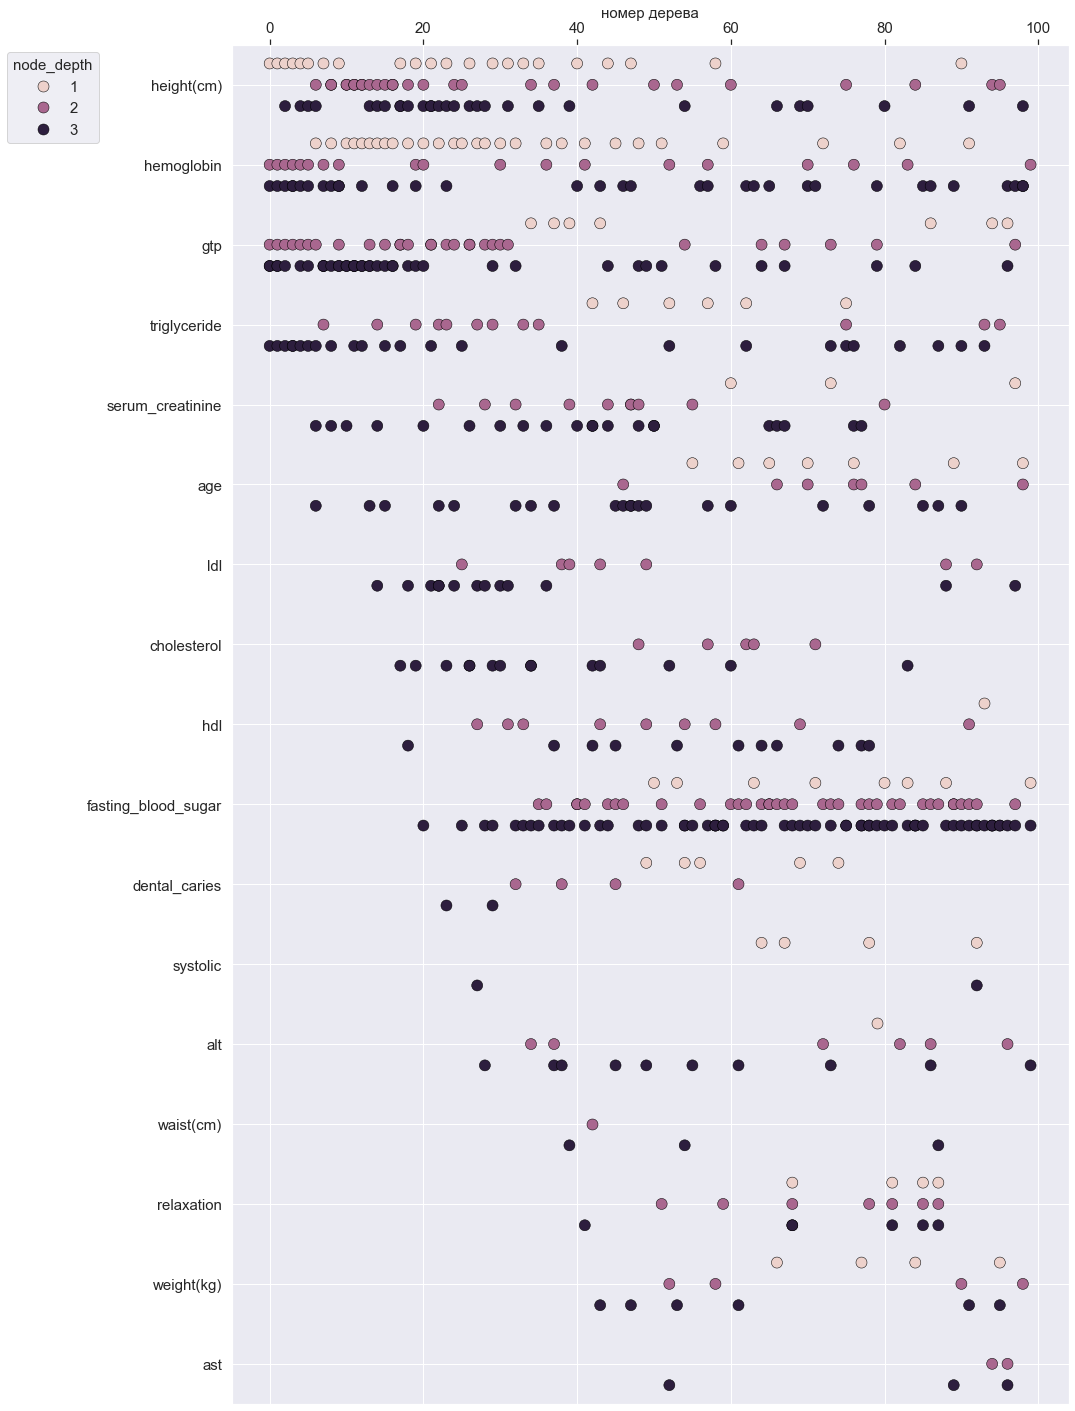

In [5]:
from local_manipulations import *

t = train_model_get_t(X_tr, y_tr)
plot_tree_info(t)

На профиле может быть виден эффект слишком маленького `eta`:

[50]	train's binary_logloss: 0.489729
[100]	train's binary_logloss: 0.456146


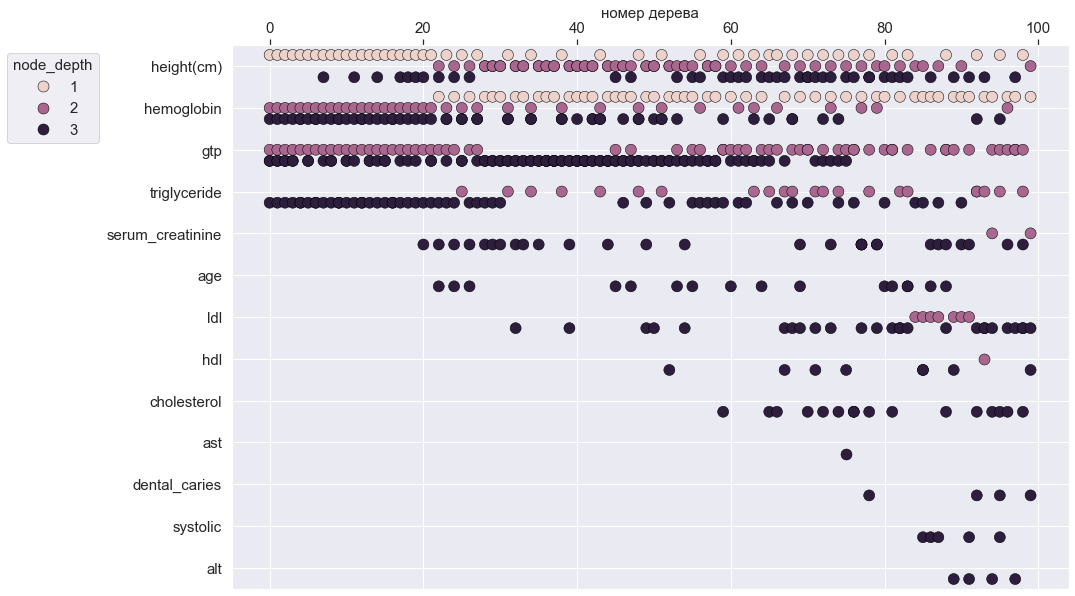

In [62]:
params = {'objective': 'binary', 'metric': 'binary_logloss', 'eta': 0.03, 'verbosity': -1}
t = train_model_get_t(X_tr, y_tr, params=params)
plot_tree_info(t, figsize=(15, 10))

Или слишком большого:

[50]	train's binary_logloss: 0.414787
[100]	train's binary_logloss: 0.392773


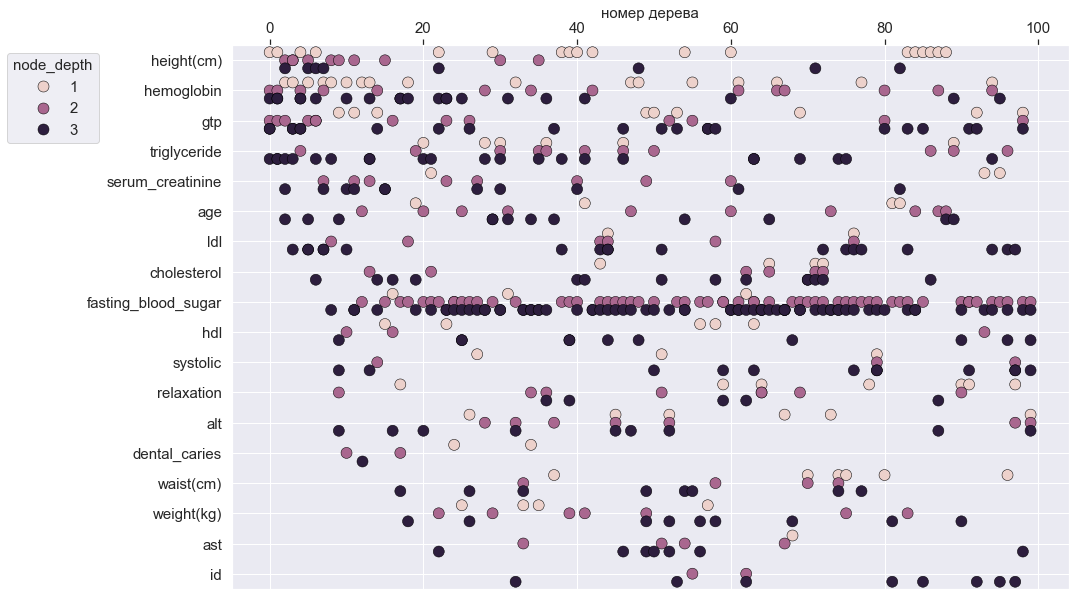

In [169]:
params = {'objective': 'binary', 'metric': 'binary_logloss', 'eta': 0.3, 'verbosity': -1}
t = train_model_get_t(X_tr, y_tr, params=params)
plot_tree_info(t, figsize=(15, 10))

### 3.3 Профиль фичей

In [6]:
from local_manipulations import *

plot_feature_info(t)

### 3.4 Кластеризация объектов по скорам в листьях

In [9]:
leaves = model.predict(X_val, pred_leaf=True)
print('leaves:\n', leaves)

scores = np.array([
    [model.get_leaf_output(i, leaves[j, i]) for i in range(leaves.shape[1])] for j in range(leaves.shape[0])
])

print('\nscores:\n', scores)

leaves:
 [[ 2 24 17 ...  1  0 18]
 [16 15 20 ...  1  2 18]
 [ 0  0  0 ...  1  0 18]
 ...
 [ 0  0  0 ...  1  0 18]
 [28  5  5 ...  1  0 18]
 [ 0  0  0 ...  1  0 18]]

scores:
 [[-1.62459065e-01  8.39490159e-02  4.38152192e-03 ...  2.92427689e-04
   2.04829234e-04  2.40897334e-04]
 [-1.61990111e-01  6.90842162e-02  5.65992366e-02 ...  2.92427689e-04
  -4.78584170e-03  2.40897334e-04]
 [-4.13494694e-01 -1.50229802e-01 -1.40260845e-01 ...  2.92427689e-04
   2.04829234e-04  2.40897334e-04]
 ...
 [-4.13494694e-01 -1.50229802e-01 -1.40260845e-01 ...  2.92427689e-04
   2.04829234e-04  2.40897334e-04]
 [-1.21563266e-01  1.38683859e-01  9.96995427e-02 ...  2.92427689e-04
   2.04829234e-04  2.40897334e-04]
 [-4.13494694e-01 -1.50229802e-01 -1.40260845e-01 ...  2.92427689e-04
   2.04829234e-04  2.40897334e-04]]


In [10]:
%%time
import umap
import plotly.express as px

mapper = umap.UMAP(n_neighbors=30, n_jobs=8, metric='euclidean')
embedding = mapper.fit_transform(scores)

px.scatter(x=embedding[:, 0], y=embedding[:, 1], color=y_val)

CPU times: total: 1min 29s
Wall time: 25.8 s


In [11]:
mapper = umap.UMAP(n_neighbors=30, n_jobs=8, metric='cosine')
embedding = mapper.fit_transform(scores)

px.scatter(x=embedding[:, 0], y=embedding[:, 1], color=y_val)

In [12]:
mapper = umap.UMAP(n_neighbors=7, n_jobs=8, metric='cosine')
embedding = mapper.fit_transform(scores)
y_pred = (model.predict(X_val) > 0.5).astype(int)

px.scatter(x=embedding[:, 0], y=embedding[:, 1], color=y_val == y_pred)

### 3.4 Кластеризация фичей

Можно использовать датафрейм с деревьями и для кластеризаци фичей - достаточно придумать по каким критериям вы хотите их кластеризовать (например, по вектору node_cnt из примера про профиль фичей). Это может быть полезно, когда фичей много.

### 3.5 Комбинации фичей

Можно спарсить датафрейм с деревьями и вытаскивать оттуда комбинации фичей вида "отец-сын-внук" (например)
- рандомные цепочки
- цепочки с максимальным суммарным гейном
- бог знает что еще!

### 3.6 Анализ взаимосвязи гиперпараметров

## 4. SHAP - важности признаков через теорию игр

На следующем семинаре!